# Grid Search - Wintrich - 4 free parameters

Wintrich site, MLE with 4 free parameters (grid search method).

For more info about the method used, see the notebook [Inference_Notes](Inference_Notes.ipynb).

This notebook has the following external dependencies:

In [1]:
import math
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import yaml

%matplotlib inline

## The mathematical (Predictive) Model

The mathematical model is available in the `models` Python module (see the notebook [Models](Models.ipynb))

In [2]:
import models

## The Data

In [3]:
profile_data = pd.read_csv('profiles_data/wintrich_10Be_profile_data.csv',
                           index_col='sample',
                           delim_whitespace=True,
                           comment='#',
                           quoting=csv.QUOTE_NONNUMERIC, quotechar='\"',
                           na_values=[-9999],
                           dtype={'depth': 'f', 'depth_g-cm-2': 'f',
                                  'C': 'f', 'std': 'f'})

profile_data

,depth,depth_g-cm-2,C,std,nuclide
sample,,,,,
s01,500,NaN,113836,5532,10Be
s03,300,NaN,56921,3797,10Be
s04,205,NaN,100178,7588,10Be
s05,150,NaN,174857,8002,10Be
s06,85,NaN,305951,12855,10Be
s07,50,NaN,483534,21025,10Be
s08,10,NaN,1423171,47585,10Be


In [4]:
with open('profiles_data/wintrich_10Be_settings.yaml') as f:
    wintrich_settings = yaml.load(f)

wintrich_settings    

{'P_0': 4.5, 'altitude': 270.0, 'latitude': 50.0, 'pressure': 995.004}

The dataset is stored as a :class:`pandas.DataFrame` object.

## Fitting the model

The grid search method is implemented in the `gridsearch` module (see the notebook [Grid-Search](Grid-Search.ipynb) for more info).

In [5]:
import gridsearch

Create a new object for setup and results

In [6]:
gstest = gridsearch.CosmogenicInferenceGC(description='wintrich 4 parameters')

Set the data

In [7]:
gstest.set_profile_measured(
    profile_data['depth'].values,
    profile_data['C'].values,
    profile_data['std'].values,
    None,
)

Set the model

In [8]:
def C_10Be_wintrich(depth, erosion, exposure,
                      density, inheritance):
    """
    10Be wintrich
    """
    return models.C_10Be(depth, erosion, exposure,
                         density, inheritance,
                         P_0=wintrich_settings['P_0'])

gstest.set_profile_model(C_10Be_wintrich)

Define the parameters to fit and their search ranges / steps. The order must be the same than the order of the arguments of the function used for the model!

In [9]:
gstest.set_parameter(
    'erosion_rate',
    [0., 5e-4, 70j],
    stats.uniform(loc=0, scale=5e-4).pdf
)

gstest.set_parameter(
    'exposure_time',
    [1e5, 1e6, 130j],
    stats.uniform(loc=1e5, scale=1e6).pdf
)

gstest.set_parameter(
    'soil_density',
    [1.7, 2.5, 60j],
    stats.uniform(loc=1.7, scale=2.5).pdf
)

gstest.set_parameter(
    'inheritance',
    [0., 1e5, 60j],
    stats.uniform(loc=0., scale=1e5).pdf
)

Grid search setup summary

In [10]:
print gstest.setup_summary()

Modelling C profile (Bayes, Grid-Search)

DESCRIPTION:
wintrich 4 parameters

MEASURED PROFILE (7 samples):
         C  depth nuclide    std
0   113836    500    None   5532
1    56921    300    None   3797
2   100178    205    None   7588
3   174857    150    None   8002
4   305951     85    None  12855
5   483534     50    None  21025
6  1423171     10    None  47585

PROFILE MODEL:
C_10Be_wintrich
10Be wintrich

'UNKNOWN' PARAMETERS (4):
erosion_rate:
	prior: <bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f238c64ced0>>
	range: [0.0, 0.0005, 70j]
exposure_time:
	prior: <bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f238c64ce90>>
	range: [100000.0, 1000000.0, 130j]
soil_density:
	prior: <bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f238c5e9050>>
	range: [1.7, 2.5, 60j]
inheritance:
	prior: <bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_fr

Perform Maximum likelihood estimation on the search grid

In [11]:
gstest.compute_mle()

Get the MLE (i.e., the parameter values at the maximum likelihood), in the same order than the definition of the parameters

In [12]:
gstest.mle

[array([ 0.]),
 array([ 253488.37209302]),
 array([ 2.5]),
 array([ 57627.11864407])]

Plot the profile log-likelihood for each parameter. The blue lines represent the difference between the profile log-likelihood and the maximum log-likelihood, The intersections between the blue line and the black lines define the confidence intervals at the given confidence levels (based on the likelihood ratio test). The red lines indicate the true values.

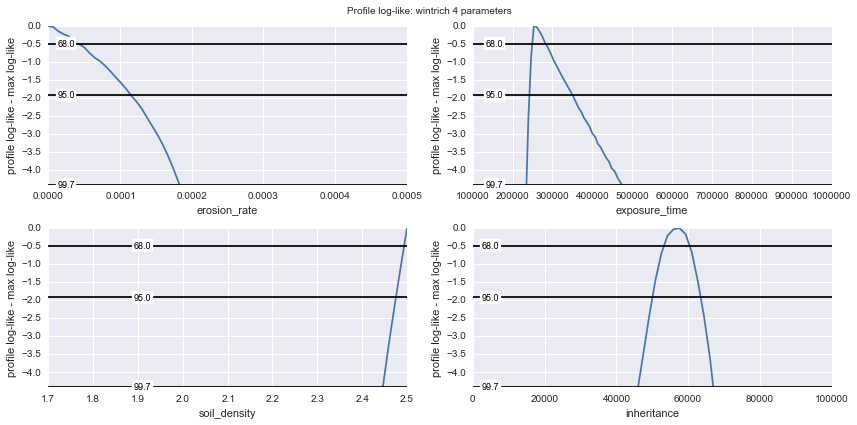

In [13]:
%matplotlib inline

def plot_proflike1d(cobj, pname, clevels=[0.68, 0.95, 0.997],
                    true_val=None, ax=None):
    
    p = cobj.parameters[pname]
    pindex = cobj.parameters.keys().index(pname)
    
    x = cobj.grid[pindex].flatten()
    proflike = cobj.proflike1d[pindex]

    if ax is None:
        ax = plt.subplot(111)
    
    difflike = proflike - cobj.maxlike
    
    ax.plot(x, difflike, label='profile loglike')
    
    ccrit = gridsearch.profile_likelihood_crit(
        cobj.proflike1d[pindex],
        cobj.maxlike,
        clevels=clevels
    )
    ccrit -= cobj.maxlike
    
    for lev, cc in zip(clevels, ccrit):
        l = ax.axhline(cc, color='k')
        hpos = x.min() + (x.max() + x.min()) * 0.05
        ax.text(hpos, cc, str(lev * 100),
                size=9, color = l.get_color(),
                ha="center", va="center",
                bbox=dict(ec='1',fc='1'))
    
    if true_val is not None:
        ax.axvline(true_val, color='r')
    
    plt.setp(ax, xlabel=pname,
             ylabel='profile log-like - max log-like',
             xlim=p['range'][0:2],
             ylim=[ccrit[-1], 0.])
    

def plot_proflike1d_all(cobj, n_subplot_cols=2, **kwargs):
    
    n_subplots = len(cobj.parameters)
    n_subplot_rows = int(math.ceil(1. * 
                                   n_subplots /
                                   n_subplot_cols))
    
    fig, aax = plt.subplots(nrows=n_subplot_rows,
                            ncols=n_subplot_cols,
                            **kwargs)
    axes = aax.flatten()
    fig.text(0.5, 0.975,
             "Profile log-like: " + cobj.description,
             horizontalalignment='center',
             verticalalignment='top')
    
    for i, pname in enumerate(cobj.parameters.keys()):
        ax = axes[i]
        plot_proflike1d(cobj, pname,
                        ax=ax)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)


plot_proflike1d_all(gstest, figsize=(12, 6))

Show the profile log-likelihood for couples of parameters. Confidence regions are also shown (also based on the likelihood ratio test).

/home/python/PythonEnvs/pygchem_py27_0/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/python/PythonEnvs/pygchem_py27_0/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


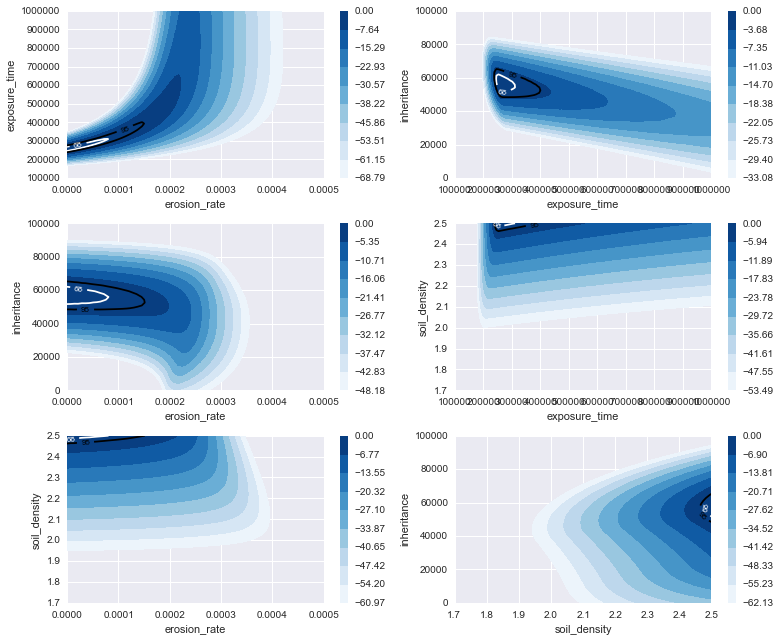

In [14]:
def plot_proflike2d(cobj, p1p2, ax=None,
                    cmap='Blues', show_colorbar=True):
    
    pname1, pname2 = p1p2
    idim = cobj.parameters.keys().index(pname2)
    jdim = cobj.parameters.keys().index(pname1)
    
    if ax is None:
        ax = plt.subplot(111)
    
    X, Y = np.meshgrid(cobj.grid[idim].flatten(),
                       cobj.grid[jdim].flatten())
    
    difflike = cobj.proflike2d[idim][jdim] - cobj.maxlike
    
    ccrit = gridsearch.profile_likelihood_crit(
        cobj.proflike2d[idim][jdim],
        cobj.maxlike,
        clevels=[0.68, 0.95]
    )
    ccrit -= cobj.maxlike
    
    contours = np.linspace(np.median(difflike),
                           0,
                           10)
    
    P2D = ax.contourf(Y, X, difflike,
                      contours,
                      cmap=plt.get_cmap(cmap))
    
    ci68 = ax.contour(Y, X, difflike,
                      [ccrit[0]], colors='w',
                      linestyles='solid')
    plt.clabel(ci68, fontsize=8, inline=True,
               fmt='68')
    ci95 = ax.contour(Y, X, difflike,
                      [ccrit[1]], colors=['k'],
                      linestyles='solid')
    plt.clabel(ci95, fontsize=8, inline=True,
               fmt='95')
    
    plt.setp(ax, xlabel=pname1, ylabel=pname2)
    
    if show_colorbar:
        plt.colorbar(P2D, ax=ax)
    
    #ax.axhline(true_exposure, color='r')
    #ax.axvline(true_erosion, color='r')
    

fig = plt.figure(figsize=(11, 9))
ax = plt.subplot(321)
plot_proflike2d(gstest, ('erosion_rate', 'exposure_time'), ax=ax)
ax2 = plt.subplot(322)
plot_proflike2d(gstest, ('exposure_time', 'inheritance'), ax=ax2)
ax3 = plt.subplot(323)
plot_proflike2d(gstest, ('erosion_rate', 'inheritance'), ax=ax3)
ax4 = plt.subplot(324)
plot_proflike2d(gstest, ('exposure_time', 'soil_density'), ax=ax4)
ax5 = plt.subplot(325)
plot_proflike2d(gstest, ('erosion_rate', 'soil_density'), ax=ax5)
ax6 = plt.subplot(326)
plot_proflike2d(gstest, ('soil_density', 'inheritance'), ax=ax6)
plt.tight_layout()

Plot the measured concentrations and the predicted profile corresponding to the best fitted data model

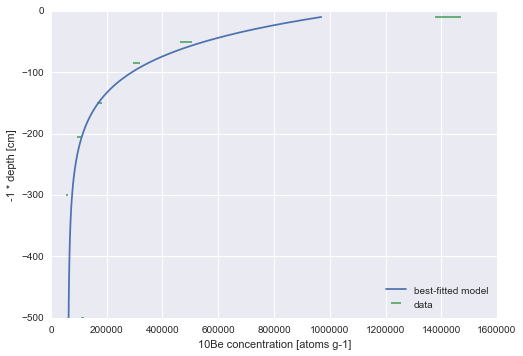

In [15]:
sns.set_context('notebook')

depths = np.linspace(profile_data['depth'].min(),
                     profile_data['depth'].max(),
                     100)
Cm_fitted = C_10Be_wintrich(depths, *gstest.mle)

plt.figure()
plt.plot(Cm_fitted, -depths, label='best-fitted model')
plt.errorbar(profile_data['C'],
             -profile_data['depth'],
             xerr=profile_data['std'],
             fmt='o', markersize=4,
             label='data')
plt.setp(plt.gca(),
         xlabel='10Be concentration [atoms g-1]',
         ylabel='-1 * depth [cm]',
         xlim=[0, None], ylim=[None, 0])

plt.legend(loc='lower right')

## Observations